**A1 - Entropy of target**

In [1]:
import pandas as pd, numpy as np
from math import log2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Load dataset
dataset = pd.read_csv("processed_fluency_dataset.csv")

# Target column
target_labels = dataset["fluency"].astype(str)

# Entropy function
def entropy_value(labels):
    class_probs = labels.value_counts(normalize=True)
    return -np.sum([p * log2(p) for p in class_probs if p > 0])

print("Entropy of target (fluency):", entropy_value(target_labels))

Entropy of target (fluency): 1.1164424909750008


**A2 - Gini index of target**

In [2]:
import pandas as pd
import numpy as np

# Load dataset
dataset = pd.read_csv("processed_fluency_dataset.csv")

# Target column
target_labels = dataset["fluency"].astype(str)

# Gini index function
def gini_index_value(labels):
    class_probs = labels.value_counts(normalize=True)
    return 1 - np.sum([p**2 for p in class_probs])

print("Gini index of target (fluency):", gini_index_value(target_labels))

Gini index of target (fluency): 0.4993193367537463


**A3 — Best root attribute (Equal-width binning)**

In [3]:
def equal_width_binning(series, bins=4):
    # Split numeric series into equal-width bins and return as strings
    return pd.cut(series, bins=bins, include_lowest=True, duplicates="drop").astype(str)

def information_gain(target_labels, x_binned):
    # Calculate information gain for a binned feature
    return entropy_value(target_labels) - sum(
        (len(target_labels[x_binned == v]) / len(target_labels)) * entropy_value(target_labels[x_binned == v])
        for v in x_binned.unique()
    )

# Load dataset
dataset = pd.read_csv("processed_fluency_dataset.csv")

# Target column
target_labels = dataset["fluency"].astype(str)

# Features to consider (exclude ID and target columns)
exclude_cols = {"filename", "student_id", "type", "fluency", "fluency_encoded"}
features = [col for col in dataset.columns if col not in exclude_cols]

# Track best feature and gain
best_feature, best_gain = None, -1

# Loop through features
for feature in features:
    # Bin numeric features, keep categorical as strings
    binned_labels = equal_width_binning(dataset[feature]) if pd.api.types.is_numeric_dtype(dataset[feature]) else dataset[feature].astype(str)
    # Compute information gain
    gain = information_gain(target_labels, binned_labels)
    # Update best if current gain is higher
    if gain > best_gain:
        best_feature, best_gain = feature, gain

# Output best feature and its gain
print(f"Best root attribute: {best_feature} | Gain: {round(best_gain, 4)}")

Best root attribute: rms | Gain: 0.123


**A4 — Best root attribute (Equal-frequency binning)**

In [4]:
def bin_feature(series, method="equal_width", bins=4):
    # Bin numeric series using equal-width or equal-frequency method
    if method == "equal_width":
        return pd.cut(series, bins=bins, labels=False, include_lowest=True, duplicates="drop")
    elif method == "equal_freq":
        return pd.qcut(series, q=bins, labels=False, duplicates="drop")

def find_best_feature_with_binning(dataset, target_col, method="equal_width", bins=4):
    # Get list of features excluding target and irrelevant columns
    features = [col for col in dataset.columns if col not in {target_col, "filename", "student_id", "fluency_encoded"}]
    best_feature, best_ig_val = None, -1
    # Loop over each feature to compute information gain
    for feature in features:
        temp_data = dataset.copy()
        # Apply binning if feature is numeric
        if pd.api.types.is_numeric_dtype(temp_data[feature]):
            temp_data[feature] = bin_feature(temp_data[feature], method, bins)
        # Calculate information gain
        ig_val = information_gain(temp_data[target_col], temp_data[feature])
        # Update best feature if higher IG found
        if ig_val > best_ig_val:
            best_feature, best_ig_val = feature, ig_val
    return best_feature, best_ig_val

# Load dataset
dataset = pd.read_csv("processed_fluency_dataset.csv")

# Find best feature using equal-frequency binning
best_feature, best_ig_val = find_best_feature_with_binning(dataset.copy(), "fluency", method="equal_freq", bins=4)

# Print result
print(f"Best root feature: {best_feature} | IG: {round(best_ig_val, 4)}")

Best root feature: rms | IG: 0.2907


**A5 — Build and evaluate our own Decision Tree**

In [5]:
class DTNode:
    def __init__(self, leaf=False, prediction=None, feature=None, children=None, edges=None):
        # Initialize a decision tree node
        self.leaf, self.prediction, self.feature, self.children, self.edges = leaf, prediction, feature, children or {}, edges

class SimpleDecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, bins=4):
        # Set tree parameters and initialize root
        self.max_depth, self.min_samples_split, self.bins, self.root = max_depth, min_samples_split, bins, None

    def _majority(self, y_data):
        # Return the most frequent class label
        return y_data.mode()[0]

    def _fit(self, X_data, y_data, features, depth):
        # Stop if pure node, max depth, too few samples, or no features left
        if len(y_data.unique()) == 1 or depth >= self.max_depth or len(y_data) < self.min_samples_split or not features:
            return DTNode(True, self._majority(y_data))

        best_feature, best_gain, best_binned, best_edges = None, -1, None, None

        # Find best feature by information gain
        for feature in features:
            if pd.api.types.is_numeric_dtype(X_data[feature]):
                binned_labels, bin_edges = pd.cut(X_data[feature], bins=self.bins, retbins=True, include_lowest=True, duplicates="drop")
                binned_labels = binned_labels.astype(str)
            else:
                binned_labels, bin_edges = X_data[feature].astype(str), None
            gain = information_gain(y_data, binned_labels)
            if gain > best_gain:
                best_feature, best_gain, best_binned, best_edges = feature, gain, binned_labels, bin_edges

        # If no feature found, make leaf
        if not best_feature:
            return DTNode(True, self._majority(y_data))

        # Recursively build child nodes
        children = {
            value: self._fit(
                X_data[best_binned == value],
                y_data[best_binned == value],
                [f for f in features if f != best_feature],
                depth + 1
            )
            for value in best_binned.unique()
        }

        return DTNode(False, None, best_feature, children, best_edges)

    def fit(self, X_data, y_data):
        # Fit the decision tree to the data
        self.root = self._fit(X_data, y_data, list(X_data.columns), 0)
        return self

    def _predict_one(self, row, node):
        # Predict a single sample
        if node.leaf:
            return node.prediction
        value = row[node.feature]
        if node.edges is not None and len(node.edges) > 0:
            try:
                value = float(value)  # Ensure numeric
                for i in range(len(node.edges) - 1):
                    if node.edges[i] <= value <= node.edges[i + 1]:
                        value = f"({node.edges[i]}, {node.edges[i + 1]}]"
                        break
            except ValueError:
                value = str(value)  # Fallback for non-numeric
        else:
            value = str(value)
        return self._predict_one(row, node.children.get(str(value), list(node.children.values())[0]))

    def predict(self, X_data):
        # Predict for all samples
        return [self._predict_one(X_data.iloc[i], self.root) for i in range(len(X_data))]

# Load dataset
dataset = pd.read_csv("processed_fluency_dataset.csv")

# Target and features
target_labels = dataset["fluency"].astype(str)
exclude_cols = {"filename", "student_id", "type", "fluency", "fluency_encoded"}
feature_columns = [col for col in dataset.columns if col not in exclude_cols]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(dataset[feature_columns], target_labels, stratify=target_labels, test_size=0.25, random_state=42)

# Train the custom decision tree
tree = SimpleDecisionTree(max_depth=5, min_samples_split=5, bins=4).fit(X_train, y_train)

# Make predictions
y_pred = tree.predict(X_test)

# Print accuracy and classification report
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print(classification_report(y_test, y_pred))

Accuracy: 0.3708
              precision    recall  f1-score   support

     Average       0.37      0.98      0.54       242
      Fluent       0.00      0.00      0.00        19
        Poor       0.80      0.02      0.04       397

    accuracy                           0.37       658
   macro avg       0.39      0.33      0.19       658
weighted avg       0.62      0.37      0.22       658



**A6 — Visualize Decision Tree using sklearn**

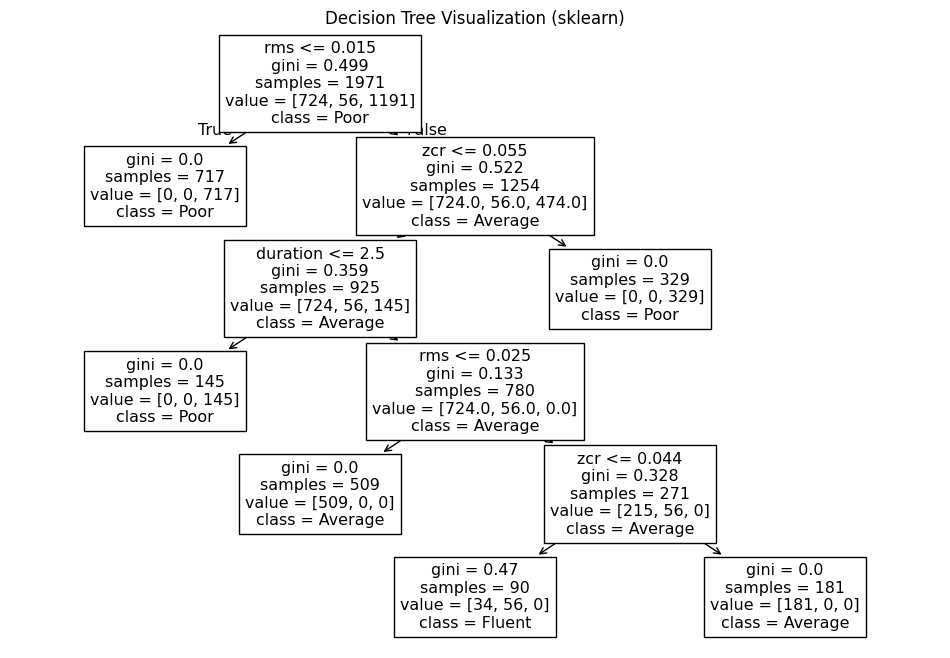

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Load dataset
dataset = pd.read_csv("processed_fluency_dataset.csv")
target_col = "fluency"
excluded_columns = {"filename", "student_id", "type", "fluency", "fluency_encoded"}
feature_columns = [col for col in dataset.columns if col not in excluded_columns]
X_data = dataset[feature_columns].copy()
y_labels = dataset[target_col].astype(str)

# Clean 'tempo' column if it looks like "[number]"
def extract_first_number(value):
    if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
        try:
            return float(value.strip("[]").split(",")[0])
        except:
            return np.nan
    return value

if "tempo" in X_data.columns:
    X_data["tempo"] = X_data["tempo"].apply(extract_first_number)

# Fill missing numeric values with median
for col in X_data.columns:
    if pd.api.types.is_numeric_dtype(X_data[col]):
        X_data[col] = X_data[col].fillna(X_data[col].median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, stratify=y_labels, test_size=0.25, random_state=42)

# Train sklearn Decision Tree
decision_tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
decision_tree_model.fit(X_train, y_train)

# Plot tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_model, feature_names=list(X_train.columns), class_names=sorted(y_labels.unique()), filled=False)
plt.title("Decision Tree Visualization (sklearn)")
plt.show()

**A7 — Decision Boundary (2 features, custom decision tree)**

/tmp/ipython-input-4185991355.py:35: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  predicted_grid = pd.factorize(custom_tree_model.predict(grid_points))[0].reshape(xx_grid.shape)


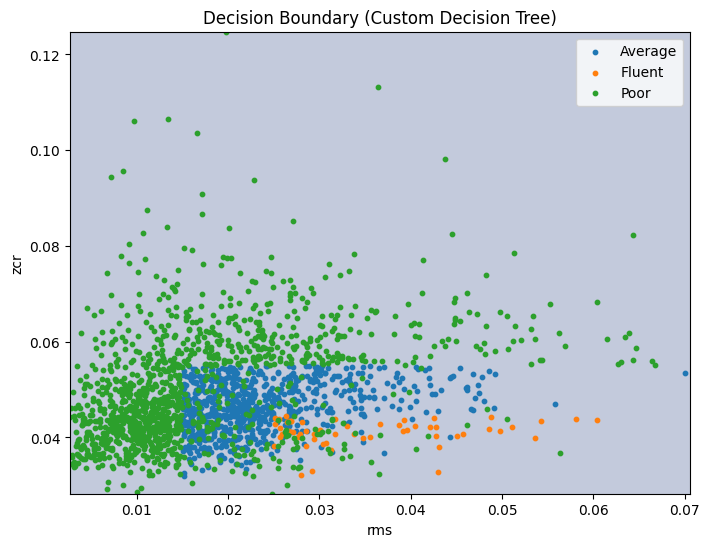

In [7]:
# Function to convert "[value]" strings to float
def extract_first_number(value):
    if isinstance(value, str) and value.startswith("[") and value.endswith("]"):
        try:
            return float(value.strip("[]").split(",")[0])
        except:
            return np.nan
    return value

# Select two features
selected_features = ["rms", "zcr"]
X_selected = dataset[selected_features].copy()
y_selected = target_labels

# Convert both features to numeric if needed
for feature in selected_features:
    X_selected[feature] = X_selected[feature].apply(extract_first_number)
    if pd.api.types.is_numeric_dtype(X_selected[feature]):
        X_selected[feature] = X_selected[feature].fillna(X_selected[feature].median())

# Train/test split
X_train, _, y_train, _ = train_test_split(X_selected, y_selected, stratify=y_selected, test_size=0.25, random_state=42)

# Train custom decision tree
custom_tree_model = SimpleDecisionTree(max_depth=3, min_samples_split=5, bins=4).fit(X_train, y_train)

# Create grid for decision boundary
x_min, x_max = X_selected[selected_features[0]].min(), X_selected[selected_features[0]].max()
y_min, y_max = X_selected[selected_features[1]].min(), X_selected[selected_features[1]].max()
xx_grid, yy_grid = np.meshgrid(np.linspace(x_min, x_max, 300),
                               np.linspace(y_min, y_max, 300))
grid_points = pd.DataFrame({selected_features[0]: xx_grid.ravel(), selected_features[1]: yy_grid.ravel()})

# Predict over grid
predicted_grid = pd.factorize(custom_tree_model.predict(grid_points))[0].reshape(xx_grid.shape)

# Plot decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx_grid, yy_grid, predicted_grid, alpha=0.3)
for class_label in sorted(y_selected.unique()):
    class_indices = y_train == class_label
    plt.scatter(X_train.loc[class_indices, selected_features[0]],
                X_train.loc[class_indices, selected_features[1]],
                s=10, label=class_label)
plt.xlabel(selected_features[0])
plt.ylabel(selected_features[1])
plt.title("Decision Boundary (Custom Decision Tree)")
plt.legend()
plt.show()